In [1]:
import torch

import triton
import triton.language as tl

try:
    # This is https://github.com/NVIDIA/apex, NOT the apex on PyPi, so it
    # should not be added to extras_require in setup.py.
    import apex
    HAS_APEX = True
except ModuleNotFoundError:
    HAS_APEX = False

DEVICE = triton.runtime.driver.active.get_active_torch_device()


In [2]:
@triton.jit
def _layer_norm_fwd_fused_welford(
    X, W, B, Y, Mean, Invrstd,
    stride, N, eps,
    BLOCK_SIZE: tl.constexpr
):
    row = tl.program_id(0)
    X += row * stride
    Y += row * stride

    # X_hat += row * stride 
    
    mean = tl.zeros([], dtype=tl.float32) 
    m2 = tl.zeros([], dtype=tl.float32) 
    count = tl.zeros([], dtype=tl.uint32) 
    for offs in tl.range(0, N, BLOCK_SIZE): 
        cols = offs + tl.arange(0, BLOCK_SIZE) 
        mask = cols < N 
        
        x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32) 
        
        block_count = tl.sum(mask, axis=0) 
        block_mean = tl.sum(x, axis=0) / block_count 
        block_m2 = tl.sum((x - block_mean) * (x - block_mean), axis=0) 
        
        delta = block_mean - mean 
        total = count + block_count 
        
        mean += (delta * block_count) / total 
        m2 += block_m2 + delta * delta * count * block_count / total 
        count = total 
        
        
    invrstd = 1.0 / tl.sqrt((m2 / count) + eps)

    tl.store(Mean + row, mean)
    tl.store(Invrstd + row, invrstd)

    for offs in tl.range(0, N, BLOCK_SIZE):
        cols = offs + tl.arange(0, BLOCK_SIZE)
        mask = cols < N

        x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32)
        w = tl.load(W + cols, mask=mask)
        b = tl.load(B + cols, mask=mask)

        x_hat = (x - mean) * invrstd
        y = x_hat * w + b

        tl.store(Y + cols, y, mask=mask)




@triton.jit
def _layer_norm_bwd_dx_fused(
    DX, DY, DW, DB, X_hat, W,
    Invrstd,
    Lock,
    stride, N,
    GROUP_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr
):
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE_N)
    mask = cols < N

    X_hat += row * stride
    DY += row * stride
    DX += row * stride

    lock_id = row % GROUP_SIZE_M
    Lock += lock_id
    Count = Lock + GROUP_SIZE_M

    DW = DW + lock_id * N + cols
    DB = DB + lock_id * N + cols

    x_hat = tl.load(X_hat + cols, mask=mask, other=0.).to(tl.float32)
    dy = tl.load(DY + cols, mask=mask, other=0.).to(tl.float32)
    w = tl.load(W + cols, mask=mask, other=0.).to(tl.float32)

    invrstd = tl.load(Invrstd + row)

    wdy = w * dy
    x_hat = tl.where(mask, x_hat, 0.)
    wdy = tl.where(mask, wdy, 0.)
    c1 = tl.sum(x_hat* wdy, axis=0) / N
    c2 = tl.sum(wdy, axis=0) / N
    dx = (wdy - (x_hat * c1 + c2)) * invrstd

    tl.store(DX + cols, dx, mask=mask)

    partial_dw = (dy * x_hat)
    partial_db = (dy)
    while tl.atomic_cas(Lock, 0, 1) == 1:
        pass
    count = tl.load(Count)
    if count == 0:
        tl.atomic_xchg(Count, 1)
    else:
        partial_dw += tl.load(DW, mask=mask).to(tl.float32)
        partial_db += tl.load(DB, mask=mask).to(tl.float32)
    
    tl.store(DW, partial_dw.to(w.dtype), mask=mask)
    tl.store(DB, partial_db.to(w.dtype), mask=mask)

    tl.debug_barrier()
    tl.atomic_xchg(Lock, 0)



@triton.jit
def _layer_norm_bwd_dxdb(
    DW, DB, FINAL_DW, FINAL_DB,
    M, N,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr
):
    pid = tl.program_id(0)
    cols = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    dw = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for i in range(0, M, BLOCK_SIZE_M):
        rows = i + tl.arange(0, BLOCK_SIZE_M)
        mask = (rows[:, None] < M) & (cols[None, :] < N)
        offs = rows[:, None] * N + cols[None, :]
        dw += tl.load(DW + offs, mask=mask, other=0.).to(tl.float32)
        db += tl.load(DB + offs, mask=mask, other=0.).to(tl.float32)

    sum_dw = tl.sum(dw, axis=0)
    sum_db = tl.sum(db, axis=0)
    tl.store(FINAL_DW + cols, sum_dw, mask=cols < N)
    tl.store(FINAL_DB + cols, sum_db, mask=cols < N)

In [3]:
class LayerNorm(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps):
        y = torch.empty_like(x)

        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        x_hat = torch.empty_like(x_arg)
        invrstd = torch.empty((M,), dtype=torch.float32, device='cuda')

        MAX_FUSED_SIZE = 65536 // x.element_size()
        # BLOCK_SIZE = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
        BLOCK_SIZE = 1024
        # if N > BLOCK_SIZE:
        #     raise RuntimeError("This layer norm doesn't support feature dim >= 64KB.")
    
        num_warps = min(max(BLOCK_SIZE // 256, 1), 8)

        _layer_norm_fwd_fused_welford[(M, )](
            x_arg, weight, bias, y, x_hat, invrstd,
            x_arg.stride(0), N, eps,
            BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps,
            num_ctas=1
        )
        ctx.save_for_backward(x_hat, weight, bias, invrstd)
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps = num_warps
        ctx.eps = eps
        return y
    
    @staticmethod
    def backward(ctx, dy):
        x_hat, weight, bias, invrstd = ctx.saved_tensors
        BLOCK_SIZE = ctx.BLOCK_SIZE
        num_warps = ctx.num_warps
        eps = ctx.eps

        N = weight.shape[0]
        GROUP_SIZE_M = 64
        if N <= 8192: GROUP_SIZE_M = 96
        if N <= 4096: GROUP_SIZE_M = 128
        if N <= 1024: GROUP_SIZE_M = 256

        locks = torch.zeros(2 * GROUP_SIZE_M, dtype=torch.int32, device='cuda')
        _dw = torch.zeros((GROUP_SIZE_M, N), dtype=torch.float32, device='cuda')
        _db = torch.zeros((GROUP_SIZE_M, N), dtype=torch.float32, device='cuda')

        dw = torch.empty((N,), dtype=weight.dtype, device='cuda')
        db = torch.empty((N,), dtype=weight.dtype, device='cuda')
        dx = torch.empty_like(dy)

        M, N = x_hat.shape
        _layer_norm_bwd_dx_fused[(M, )](
            dx, dy, _dw, _db, x_hat, weight,
            invrstd,
            locks,
            x_hat.stride(0), N,
            GROUP_SIZE_M=GROUP_SIZE_M,
            BLOCK_SIZE_N=BLOCK_SIZE,
            num_warps=num_warps
        )

        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_SIZE_N']), )
        _layer_norm_bwd_dxdb[grid](
            _dw, _db, dw, db, 
            min(GROUP_SIZE_M, M), N,
            BLOCK_SIZE_M=32,
            BLOCK_SIZE_N=128,
            num_ctas=1
        )
        return dx, None, dw, db, None

In [4]:
layer_norm = LayerNorm.apply


def test_layer_norm(M, N, dtype, eps=1e-5, device='cuda'):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    # forward pass
    y_tri = layer_norm(x, w_shape, weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    # backward pass (triton)
    y_tri.backward(dy, retain_graph=True)
    dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None
    # backward pass (torch)
    y_ref.backward(dy, retain_graph=True)
    dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
    # compare
    assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=0)
    # assert torch.allclose(dx_tri, dx_ref, atol=1e-2, rtol=0)
    # assert torch.allclose(db_tri, db_ref, atol=1e-2, rtol=0)
    # assert torch.allclose(dw_tri, dw_ref, atol=1e-2, rtol=0)


In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg='provider',
        line_vals=['triton', 'torch'] + (['apex'] if HAS_APEX else []),
        line_names=['Triton', 'Torch'] + (['Apex'] if HAS_APEX else []),
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'forward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='forward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():

        if provider == "triton":
            return layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "apex":
            apex_layer_norm = (apex.normalization.FusedLayerNorm(w_shape).to(x.device).to(x.dtype))
            return apex_layer_norm(x)  # noqa: F811, E704

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


layer-norm-backward:
          N       Triton        Torch
0    1024.0  1294.538275  1000.549669
1    1536.0  1404.342820  1264.360085
2    2048.0  1762.312633  1432.480902
3    2560.0  1756.997375  1556.674568
4    3072.0  2008.766219  1657.390923
5    3584.0  1941.807453  1721.395924
6    4096.0  2084.644183  1744.718866
7    4608.0  2021.676026  1772.573996
8    5120.0  2114.064495  1790.601127
9    5632.0  2010.867537  1775.605883
10   6144.0  2045.336863  1764.289443
11   6656.0  1965.324051  1755.730041
12   7168.0  1964.676637  1739.344075
13   7680.0  1899.594268  1726.145654
14   8192.0  1880.853825  1708.474088
15   8704.0  1864.622565  1706.797336
16   9216.0  1858.445051  1700.393549
17   9728.0  1837.232071  1687.241253
18  10240.0  1851.299493  1691.251564
19  10752.0  1831.954703  1702.233795
20  11264.0  1835.508626  1693.237770
21  11776.0  1824.300140  1694.102794
22  12288.0  1841.222156  1700.393513
23  12800.0  1831.637785  1708.891743
24  13312.0  1846.584699  170

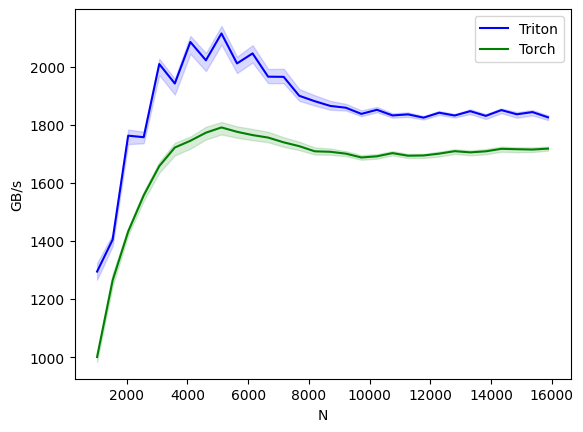

In [6]:
test_layer_norm(1151, 8192, torch.float16)
bench_layer_norm.run(save_path='.', print_data=True)

In [1]:
import torch

import triton
import triton.language as tl

try:
    # This is https://github.com/NVIDIA/apex, NOT the apex on PyPi, so it
    # should not be added to extras_require in setup.py.
    import apex
    HAS_APEX = True
except ModuleNotFoundError:
    HAS_APEX = False

DEVICE = triton.runtime.driver.active.get_active_torch_device()


@triton.jit
def _layer_norm_fwd_fused(
    X,  # pointer to the input
    Y,  # pointer to the output
    W,  # pointer to the weights
    B,  # pointer to the biases
    Mean,  # pointer to the mean
    Rstd,  # pointer to the 1/std
    stride,  # how much to increase the pointer when moving by 1 row
    N,  # number of columns in X
    eps,  # epsilon to avoid division by zero
    BLOCK_SIZE: tl.constexpr,
):
    # Map the program id to the row of X and Y it should compute.
    row = tl.program_id(0)
    Y += row * stride
    X += row * stride
    # Compute mean
    mean = 0
    _mean = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        a = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
        _mean += a
    mean = tl.sum(_mean, axis=0) / N
    # Compute variance
    _var = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        x = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
        x = tl.where(cols < N, x - mean, 0.)
        _var += x * x
    var = tl.sum(_var, axis=0) / N
    rstd = 1 / tl.sqrt(var + eps)
    # Write mean / rstd
    tl.store(Mean + row, mean)
    tl.store(Rstd + row, rstd)
    # Normalize and apply linear transformation
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        mask = cols < N
        w = tl.load(W + cols, mask=mask)
        b = tl.load(B + cols, mask=mask)
        x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32)
        x_hat = (x - mean) * rstd
        y = x_hat * w + b
        # Write output
        tl.store(Y + cols, y, mask=mask)

In [2]:
@triton.jit
def _layer_norm_bwd_dx_fused(DX,  # pointer to the input gradient
                             DY,  # pointer to the output gradient
                             DW,  # pointer to the partial sum of weights gradient
                             DB,  # pointer to the partial sum of biases gradient
                             X,  # pointer to the input
                             W,  # pointer to the weights
                             Mean,  # pointer to the mean
                             Rstd,  # pointer to the 1/std
                             Lock,  # pointer to the lock
                             stride,  # how much to increase the pointer when moving by 1 row
                             N,  # number of columns in X
                             GROUP_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr):
    # Map the program id to the elements of X, DX, and DY it should compute.
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE_N)
    mask = cols < N
    X += row * stride
    DY += row * stride
    DX += row * stride
    # Offset locks and weights/biases gradient pointer for parallel reduction
    lock_id = row % GROUP_SIZE_M
    Lock += lock_id
    Count = Lock + GROUP_SIZE_M
    DW = DW + lock_id * N + cols
    DB = DB + lock_id * N + cols
    # Load data to SRAM
    x = tl.load(X + cols, mask=mask, other=0).to(tl.float32)
    dy = tl.load(DY + cols, mask=mask, other=0).to(tl.float32)
    w = tl.load(W + cols, mask=mask).to(tl.float32)
    mean = tl.load(Mean + row)
    rstd = tl.load(Rstd + row)
    # Compute dx
    xhat = (x - mean) * rstd
    wdy = w * dy
    xhat = tl.where(mask, xhat, 0.)
    wdy = tl.where(mask, wdy, 0.)
    c1 = tl.sum(xhat * wdy, axis=0) / N
    c2 = tl.sum(wdy, axis=0) / N
    dx = (wdy - (xhat * c1 + c2)) * rstd
    # Write dx
    tl.store(DX + cols, dx, mask=mask)
    # Accumulate partial sums for dw/db
    partial_dw = (dy * xhat).to(w.dtype)
    partial_db = (dy).to(w.dtype)
    while tl.atomic_cas(Lock, 0, 1) == 1:
        pass
    count = tl.load(Count)
    # First store doesn't accumulate
    if count == 0:
        tl.atomic_xchg(Count, 1)
    else:
        partial_dw += tl.load(DW, mask=mask)
        partial_db += tl.load(DB, mask=mask)
    tl.store(DW, partial_dw, mask=mask)
    tl.store(DB, partial_db, mask=mask)

    # need a barrier to ensure all threads finished before
    # releasing the lock
    tl.debug_barrier()

    # Release the lock
    tl.atomic_xchg(Lock, 0)


@triton.jit
def _layer_norm_bwd_dwdb(DW,  # pointer to the partial sum of weights gradient
                         DB,  # pointer to the partial sum of biases gradient
                         FINAL_DW,  # pointer to the weights gradient
                         FINAL_DB,  # pointer to the biases gradient
                         M,  # GROUP_SIZE_M
                         N,  # number of columns
                         BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr):
    # Map the program id to the elements of DW and DB it should compute.
    pid = tl.program_id(0)
    cols = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    dw = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    # Iterate through the rows of DW and DB to sum the partial sums.
    for i in range(0, M, BLOCK_SIZE_M):
        rows = i + tl.arange(0, BLOCK_SIZE_M)
        mask = (rows[:, None] < M) & (cols[None, :] < N)
        offs = rows[:, None] * N + cols[None, :]
        dw += tl.load(DW + offs, mask=mask, other=0.)
        db += tl.load(DB + offs, mask=mask, other=0.)
    # Write the final sum to the output.
    sum_dw = tl.sum(dw, axis=0)
    sum_db = tl.sum(db, axis=0)
    tl.store(FINAL_DW + cols, sum_dw, mask=cols < N)
    tl.store(FINAL_DB + cols, sum_db, mask=cols < N)

layer-norm-backward:
          N       Triton        Torch
0    1024.0  1323.959634  1030.035412
1    1536.0  1360.609050  1266.396107
2    2048.0  1699.474924  1442.332863
3    2560.0  1529.428227  1562.240789
4    3072.0  1720.857816  1676.827323
5    3584.0  1889.812562  1724.631656
6    4096.0  2038.048521  1747.626584
7    4608.0  1933.849218  1759.355749
8    5120.0  2105.574212  1797.969769
9    5632.0  2228.426657  1783.292547
10   6144.0  2335.358554  1779.257961
11   6656.0  2416.930451  1763.908864
12   7168.0  2474.724208  1749.292735
13   7680.0  2527.095158  1736.052967
14   8192.0  2574.772336  1708.474088
15   8704.0  1901.215082  1719.308678
16   9216.0  1986.775643  1712.737554
17   9728.0  2081.377298  1702.815773
18  10240.0  2143.450533  1701.681303
19  10752.0  2210.852923  1702.760317
20  11264.0  2274.119887  1693.237770
21  11776.0  2335.132362  1702.233784
22  12288.0  2388.555779  1701.313149
23  12800.0  2416.519238  1706.666710
24  13312.0  2435.064045  170

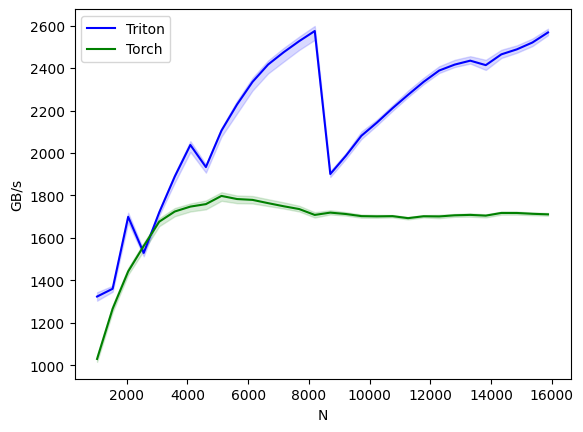

In [3]:
class LayerNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps):
        # allocate output
        y = torch.empty_like(x)
        # reshape input data into 2D tensor
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        mean = torch.empty((M, ), dtype=torch.float32, device=x.device)
        rstd = torch.empty((M, ), dtype=torch.float32, device=x.device)
        # Less than 64KB per feature: enqueue fused kernel
        MAX_FUSED_SIZE = 65536 // x.element_size()
        BLOCK_SIZE = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
        if N > BLOCK_SIZE:
            raise RuntimeError("This layer norm doesn't support feature dim >= 64KB.")
        # heuristics for number of warps
        num_warps = min(max(BLOCK_SIZE // 256, 1), 8)
        # enqueue kernel
        _layer_norm_fwd_fused[(M, )](  #
            x_arg, y, weight, bias, mean, rstd,  #
            x_arg.stride(0), N, eps,  #
            BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps, num_ctas=1)
        ctx.save_for_backward(x, weight, bias, mean, rstd)
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps = num_warps
        ctx.eps = eps
        return y

    @staticmethod
    def backward(ctx, dy):
        x, w, b, m, v = ctx.saved_tensors
        # heuristics for amount of parallel reduction stream for DW/DB
        N = w.shape[0]
        GROUP_SIZE_M = 64
        if N <= 8192: GROUP_SIZE_M = 96
        if N <= 4096: GROUP_SIZE_M = 128
        if N <= 1024: GROUP_SIZE_M = 256
        # allocate output
        locks = torch.zeros(2 * GROUP_SIZE_M, dtype=torch.int32, device=w.device)
        _dw = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        _db = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        dw = torch.empty((N, ), dtype=w.dtype, device=w.device)
        db = torch.empty((N, ), dtype=w.dtype, device=w.device)
        dx = torch.empty_like(dy)
        # enqueue kernel using forward pass heuristics
        # also compute partial sums for DW and DB
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        _layer_norm_bwd_dx_fused[(M, )](  #
            dx, dy, _dw, _db, x, w, m, v, locks,  #
            x_arg.stride(0), N,  #
            BLOCK_SIZE_N=ctx.BLOCK_SIZE,  #
            GROUP_SIZE_M=GROUP_SIZE_M,  #
            num_warps=ctx.num_warps)
        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_SIZE_N']), )
        # accumulate partial sums in separate kernel
        _layer_norm_bwd_dwdb[grid](
            _dw, _db, dw, db, min(GROUP_SIZE_M, M), N,  #
            BLOCK_SIZE_M=32,  #
            BLOCK_SIZE_N=128, num_ctas=1)
        return dx, None, dw, db, None


layer_norm = LayerNorm.apply


def test_layer_norm(M, N, dtype, eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    # forward pass
    y_tri = layer_norm(x, w_shape, weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    # backward pass (triton)
    y_tri.backward(dy, retain_graph=True)
    dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None
    # backward pass (torch)
    y_ref.backward(dy, retain_graph=True)
    dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
    # compare
    assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dx_tri, dx_ref, atol=1e-2, rtol=0)
    assert torch.allclose(db_tri, db_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dw_tri, dw_ref, atol=1e-2, rtol=0)


@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg='provider',
        line_vals=['triton', 'torch'] + (['apex'] if HAS_APEX else []),
        line_names=['Triton', 'Torch'] + (['Apex'] if HAS_APEX else []),
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'forward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='forward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():

        if provider == "triton":
            return layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "apex":
            apex_layer_norm = (apex.normalization.FusedLayerNorm(w_shape).to(x.device).to(x.dtype))
            return apex_layer_norm(x)  # noqa: F811, E704

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


test_layer_norm(1151, 8192, torch.float16)
bench_layer_norm.run(save_path='.', print_data=True)

In [1]:
import triton
import triton.language as tl

In [ ]:
@triton.jit
def layer_norm_fwd_fused(
    X_ptr, Y_ptr, W_ptr, B_ptr,
    Mean, Invrstd,
    stride: tl.constexpr,
    N: tl.constexpr,
    eps: tl.constexpr,
    BLOCK_SIZE: tl.constexpr
):
    pid = tl.program_id(0)

    X = X_ptr + pid * stride
    Y = Y_ptr + pid * stride

    mean = tl.zeros([], dtype=tl.float32)
    m2 = tl.zeros([], dtype=tl.float32)
    count = tl.zeros([], dtype=tl.uint32)
    for offs in range(0, N, BLOCK_SIZE):
        cols = offs + tl.arange(0, BLOCK_SIZE)
        mask = cols < N

        x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32)

        block_count = tl.sum(mask, axis=0)
        block_mean = tl.sum(x, axis=0) / block_count
        block_m2 = tl.sum((x - block_mean) * (x - block_mean), axis=0)

        delta = block_mean - mean
        total = count + block_count

        mean += (delta * block_count) / total
        m2 += block_m2 + delta * delta * count + block_count / total
        count = total

    invrstd = 1.0 / tl.sqrt((m2 / count) + eps)

    tl.store(Mean + pid, mean)
    tl.store(Invrstd + pid, invrstd)

    for offs in range(0, N, BLOCK_SIZE):
        cols = offs + tl.arange(0, BLOCK_SIZE)
        mask = cols < N

        x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32)
        w = tl.load(W + cols, mask=mask).to(tl.float32)
        b = tl.load(B + cols, mask=mask).to(tl.float32)

        x_hat = (x - mean) * invrstd
        y = x_hat * w + b
        tl.store(Y + cols, y, mask=mask)

In [ ]:
@triton.jit
def layer_norm_bwd_dx_fused(
    DY_ptr, DX_ptr, DW_ptr, DB_ptr, X_ptr, W_ptr, 
    Mean, Invrstd,
    Lock,
    stride,
    N: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr
):
    pid = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE_N)
    mask = cols < N

    DY = DY_ptr + pid * stride
    DX = DX_ptr + pid * stride
    X = X_ptr + pid * stride

    lock_id = pid % GROUP_SIZE_M
    Lock += lock_id
    Count = Lock + GROUP_SIZE_M
    DW = DW_ptr + pid * stride + cols
    DB = DB_ptr + pid * stride + cols

    x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32)
    dy = tl.load(DY + cols, mask=mask, other=0.).to(tl.float32)
    w = tl.load(W_ptr + cols, mask=mask).to(tl.float32)
    mean = tl.load(Mean + pid).to(tl.float32)
    invrstd = tl.load(Invrstd + pid).to(tl.float32)

    x_hat = (x - mean) * invrstd
    wdy = w * dy
    x_hat = tl.where(mask, x_hat, 0.)
    wdy = tl.where(mask, wdy, 0.)
    c1 = tl.sum(x_hat * wdy, axis=0) / N
    c2 = tl.sum(wdy, axis=0) / N
    dx = (wdy - (x_hat * c1 + c2)) * invrstd

    tl.store(DX + cols, dx, mask=mask)

    partial_dw = (dy * x_hat).to(w.dtype)
    partial_db = (dy).to(w.dtype)

    while tl.atomic_cas(Lock, 0, 1) == 1:
        pass

    count = tl.load(Count)
    if count == 0:
        tl.atomic_xchg(Count, 1)
    else:
        partial_dw += tl.load(DW, mask=mask).to(tl.float32)
        partial_db += tl.load(DB, mask=mask).to(tl.float32)
    tl.store(DW, partial_dw, mask=mask)
    tl.store(DB, partial_db, mask=mask)

    tl.debug_barrier()

    tl.atomic_xchg(Lock, 0)


@triton.jit
def layer_norm_bwd_dwdb_fused(
    DW_ptr, DB_ptr, Partial_DW, Partial_DB,
    stride,
    M, N,
    BLOCK_SIZE_M, BLOCK_SIZE_N
):
    pid = tl.program_id(0)
    cols = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    mask_cols = cols < N

    dw = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    for offs in range(0, M, BLOCK_SIZE_M):
        row = offs + tl.arange(0, BLOCK_SIZE_M)
        idx = row[:, None] * stride + cols[None, :]
        mask = (row[:, None] < M) & (cols[None, :] < N)

        dw += tl.load(Partial_DW + idx, mask=mask, other=0.).to(tl.float32)
        db += tl.load(Partial_DB + idx, mask=mask, other=0.).to(tl.float32)

    DW = tl.sum(dw, axis=0)
    DB = tl.sum(db, axis=0)

    tl.store(DW_ptr + cols, DW, mask=mask_cols)
    tl.store(DB_ptr + cols, DB, mask=mask_cols)


In [ ]:
@triton.jit
def layer_norm_fwd_fused(
    X_ptr, Y_ptr, X_hat_ptr, W_ptr, B_ptr,
    Mean, Invrstd,
    stride, N,
    BLOCK_SIZE_N: tl.constexpr
):
    row = tl.program_id(0)

    X_ptr += row * stride
    Y_ptr += row * stride
    X_hat_ptr += row * stride

    mean = tl.zeros([], dtype=tl.float32)
    m2 = tl.zeros([], dtype=tl.float32)
    count = tl.zeros([], dtype=tl.float32)
    for offs in range(0, N, BLOCK_SIZE_N):
        cols = offs + tl.arange(0, BLOCK_SIZE_N)
        mask = cols < N

        x = tl.load(X_ptr + cols, mask=mask, other=0.).to(tl.float32)

        block_count = tl.sum(mask, axis=0)
        block_mean = tl.sum(x, axis=0) / block_count
        block_m2 = tl.sum((x - block_mean) * (x - block_mean), axis=0)

        delta = block_mean - mean
        total = count + block_count

        mean += delta * block_count / total
        m2 += block_m2 + delta * delta * count + block_count / total
        count = total

    invrstd = 1.0 / tl.sqrt((m2 / count) + 1e-7)

    tl.store(Mean + row, mean)
    tl.store(Invrstd + row, invrstd)

    for offs in range(0, N, BLOCK_SIZE_N):
        cols = offs + tl.arange(0, BLOCK_SIZE_N)
        mask = cols < N

        x = tl.load(X_ptr + cols, mask=mask, other=0.).to(tl.float32)
        w = tl.load(W_ptr + row).to(tl.float32)
        b = tl.load(B_ptr + row).to(tl.float32)

        x_hat = (x - mean) * invrstd

        y = x_hat * w + b
        tl.store(Y_ptr + cols, y, mask=mask)
        tl.store(X_hat_ptr + cols, x_hat, mask=mask)

In [ ]:
# BN

@triton.jit 
def batch_norm_fwd_fused(
    x_ptr, y_ptr, w_ptr, b_ptr,
    Mean, Invrstd,
    N, C, eps,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_C: tl.constexpr,
):
    col = tl.program_id(0)
    col_offs = col * BLOCK_SIZE_C + tl.arange(0, BLOCK_SIZE_C)
    col_mask = col_offs < C 

    sum = tl.zeros([BLOCK_SIZE_C], dtype=tl.float32)
    sum_square = tl.zeros([BLOCK_SIZE_C], dtype=tl.float32)
    for offs in range(0, N, BLOCK_SIZE_N):
        row_offs = offs + tl.arange(0, BLOCK_SIZE_N)
        row_mask = row_offs < N 

        offset = row_offs[:, None] * C + col_offs[None, :]
        mask = row_mask[:, None] & col_mask[None, :]

        x = tl.load(x_ptr + offset, mask=mask, other=0.).to(tl.float32)

        sum += tl.sum(x, axis=0)
        sum_square += tl.sum(x * x, axis=0)

    mean = sum / N
    var = (sum_square / N) - mean * mean 
    invrstd = 1.0 / tl.sqrt(var + eps)

    tl.store(Mean + col_offs, mean, mask=col_mask)
    tl.store(Invrstd + col_offs, invrstd, mask=col_mask)

    w = tl.load(w_ptr + col_offs, mask=col_mask).to(tl.float32)
    b = tl.load(b_ptr + col_offs, mask=col_mask).to(tl.float32)

    for offs in range(0, N, BLOCK_SIZE_N):
        row_offs = offs + tl.arange(0, BLOCK_SIZE_N)
        row_mask = row_offs < N

        offset = row_offs[:, None] * C + col_offs[None, :]
        mask = row_mask[:, None] & col_mask[None, :]

        x = tl.load(x_ptr + offset, mask=mask, other=0.).to(tl.float32)

        x_hat = (x - mean) * invrstd
        y = x_hat * w[None, :] + b[None, :]

        tl.store(y_ptr + offset, y, mask=mask)


@triton.jit
def batch_norm_bwd_fused(
    dy_ptr, x_ptr, w_ptr,
    dx_ptr, dw_ptr, db_ptr,
    Mean, Invrstd,
    N, C,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_C: tl.constexpr
):
    col = tl.program_id(0)
    col_offs = col * BLOCK_SIZE_C + tl.arange(0, BLOCK_SIZE_C)
    col_mask = col_offs < C

    mean = tl.load(Mean + col_offs, mask=col_mask).to(tl.float32)
    invrstd = tl.load(Invrstd + col_offs, mask=col_mask).to(tl.float32)

    dw = tl.zeros([BLOCK_SIZE_C], dtype=tl.float32)
    db = tl.zeros([BLOCK_SIZE_C], dtype=tl.float32)
    for offs in range(0, N, BLOCK_SIZE_N):
        row_offs = offs + tl.arange(0, BLOCK_SIZE_N)
        row_mask = row_offs < N 

        offset = row_offs[:, None] * C + col_offs[None, :]
        mask = row_mask[:, None] & col_mask[None, :]

        dy = tl.load(dy_ptr + offset, mask=mask, other=0.).to(tl.float32)
        x = tl.load(x_ptr + offset, mask=mask, other=0.).to(tl.float32)

        x_hat = (x - mean) * invrstd
        dw += tl.sum(dy * x_hat, axis=0)
        db += tl.sum(dy, axis=0)

    tl.store(dw_ptr + col_offs, dw, mask=col_mask)
    tl.store(db_ptr + col_offs, db, mask=col_mask)

    w = tl.load(w_ptr + col_offs, mask=col_mask).to(tl.float32)
    for offs in range(0, N, BLOCK_SIZE_N):
        row_offs = offs + tl.arange(0, BLOCK_SIZE_N)
        row_mask = row_offs < N 

        offset = row_offs[:, None] * C + col_offs[None, :]
        mask = row_mask[:, None] & col_mask[None, :]

        dy = tl.load(dy_ptr + offset, mask=mask, other=0.).to(tl.float32)
        x = tl.load(x_ptr + offset, mask=mask, other=0.).to(tl.float32)

        x_hat = (x - mean) * invrstd
        dx = (w[None, :] * invrstd[None, :] / N * (N * dy - db[None, :] - xhat * dw[None, :]))
        tl.store(dx_ptr + offset, dx, mask=mask)




In [ ]:
@triton.jit 
def bn_fwd_reduce_fused(
    x_ptr, sum_ptr, sum_square_ptr,
    M, HW,
    stride_n, stride_c,
    BLOCK_SIZE: tl.constexpr
):
    c = tl.program_id(0)
    pid = tl.program_id(1)

    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < M 

    n = offs // HW 
    s = offs - n * HW

    x_ptr += n * stride_n + c * stride_c + s

    x = tl.load(x_ptr, mask=mask, other=0.).to(tl.float32)

    sum = tl.sum(x, axis=0)
    sum_square = tl.sum(x * x, axis=0)

    tl.atomic_add(sum_ptr + c, sum)
    tl.atomic_add(sum_square_ptr + c, sum_square)


@triton.jit
def bn_fwd_norm_fused(
    x_ptr, sum_ptr, sum_square_ptr, y_ptr, x_hat_ptr,
    w_ptr, b_ptr,
    M, HW,
    stride_n, stride_c,
    BLOCK_SIZE: tl.constexpr
): 
    c = tl.program_id(0)
    pid = tl.program_id(1)

    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < M

    n = offs // HW
    s = offs - n * HW

    x_ptr += n * stride_n + c * stride_c + s
    y_ptr += n * stride_n + c * stride_c + s
    x_hat_ptr += n * stride_n + c * stride_c + s

    sum = tl.load(sum_ptr + c).to(tl.float32)
    sum_square = tl.load(sum_square_ptr + c).to(tl.float32)

    mean = sum / M
    var = (sum_square / M) - mean * mean
    invrstd = 1.0 / tl.sqrt(var + 1e-7)

    x = tl.load(x_ptr, mask=mask, other=0.).to(tl.float32)
    w = tl.load(w_ptr + c).to(tl.float32)
    b = tl.load(b_ptr + c).to(tl.float32)

    x_hat = (x - mean) * invrstd
    y = x_hat * w + b

    tl.store(x_hat_ptr, x_hat, mask=mask)
    tl.store(y_ptr, y, mask=mask)


@triton.jit
def bn_bwd_reduce_fused(
    x_hat_ptr, dy_ptr, dw_ptr, db_ptr,
    M, HW,
    stride_n, stride_c,
    BLOCK_SIZE: tl.constexpr
):
    c = tl.program_id(0)
    pid = tl.program_id(1)

    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < M

    n = offs // HW
    s = offs - n * HW

    x_hat_ptr += n * stride_n + c * stride_c + s
    dy_ptr += n * stride_n + c * stride_c + s

    x_hat = tl.load(x_hat_ptr, mask=mask, other=0.).to(tl.float32)
    dy = tl.load(dy_ptr, mask=mask, other=0.).to(tl.float32)

    sum_dy = tl.sum(dy, axis=0)
    sum_dy_xhat = tl.sum(dy * x_hat, axis=0)

    tl.atomic_add(dw_ptr + c, sum_dy_xhat)
    tl.atomic_add(db_ptr + c, sum_dy)


@triton.jit
def bn_bwd_dx_fused(
    x_hat_ptr, dy_ptr, invrstd_ptr, w_ptr,
    dw_ptr, db_ptr, dx_ptr,
    M, HW,
    stride_n, stride_c,
    BLOCK_SIZE: tl.constexpr
):
    c = tl.program_id(0)
    pid = tl.program_id(1)

    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < M

    n = offs // HW
    s = offs - n * HW

    x_hat_ptr += n * stride_n + c * stride_c + s
    dy_ptr += n * stride_n + c * stride_c + s
    dx_ptr += n * stride_n + c * stride_c + s

    x_hat = tl.load(x_hat_ptr, mask=mask, other=0.).to(tl.float32)
    dy = tl.load(dy_ptr, mask=mask, other=0.).to(tl.float32)

    invrstd = tl.load(invrstd_ptr + c).to(tl.float32)
    w = tl.load(w_ptr + c).to(tl.float32)
    dw = tl.load(dw_ptr + c).to(tl.float32)
    db = tl.load(db_ptr + c).to(tl.float32)

    dx = (dy - (db / M) - x_hat * (dw / M)) * w * invrstd
    tl.store(dx_ptr, dx, mask=mask)

In [ ]:
@triton.jit
def bn_fwd_norm_quant_pack_fused_kernel(
    x_ptr, sum_ptr, sum_square_ptr, w_ptr, b_ptr,
    y_ptr, x_hat_packed_ptr, scale_ptr, min_ptr,
    mean_ptr, var_ptr,
    M, HW,
    stride_n, stride_c, stride_packed_c, stride_stats_c,
    BLOCK_SIZE: tl.constexpr,
    BITS: tl.constexpr,
    VPW: tl.constexpr,
    NWORDS: tl.constexpr,
    TOTAL_WORDS: tl.constexpr,
    QMAX: tl.constexpr
):
    c = tl.program_id(0)
    pid = tl.program_id(1)

    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < M

    packed_offs = pid * NWORDS + tl.arange(0, NWORDS)
    packed_mask = packed_offs < TOTAL_WORDS

    n = offs // HW
    s = offs - n * HW

    x_ptr += n * stride_n + c * stride_c + s
    y_ptr += n * stride_n + c * stride_c + s
    x_hat_packed_ptr += c * stride_packed_c + packed_offs

    x = tl.load(x_ptr, mask=mask, other=0.).to(tl.float32)
    sum = tl.load(sum_ptr + c).to(tl.float32)
    sum_square = tl.load(sum_square_ptr + c).to(tl.float32)
    w = tl.load(w_ptr + c).to(tl.float32)
    b = tl.load(b_ptr + c).to(tl.float32)

    mean = sum / M
    var = (sum_square / M) - mean * mean
    var = tl.maximum(var, 0.0)
    invrstd = 1.0 / tl.sqrt(var + 1e-7)

    if pid == 0:
        tl.store(mean_ptr + c, mean)
        tl.store(var_ptr + c, var)

    x_hat = (x - mean) * invrstd
    y = x_hat * w + b

    tl.store(y_ptr, y.to(tl.bfloat16), mask=mask)

    neg_inf = tl.full((), -float("inf"), tl.float32)
    pos_inf = tl.full((),  float("inf"), tl.float32)
    x_hat_valid_for_max = tl.where(mask, x_hat, neg_inf)
    x_hat_valid_for_min = tl.where(mask, x_hat, pos_inf)

    max = tl.max(x_hat_valid_for_max, axis=0)
    min = tl.min(x_hat_valid_for_min, axis=0)

    rng = max - min
    scale = (rng / tl.full([], QMAX, tl.float32))
    scale = tl.where(rng > 0.0, scale, tl.full([], 1.0, tl.float32))

    inv_scale = tl.full([], 1.0, tl.float32) / scale

    tl.store(scale_ptr + c * stride_stats_c + pid, scale.to(tl.bfloat16))
    tl.store(min_ptr + c * stride_stats_c + pid, min.to(tl.bfloat16))


    j = tl.arange(0, VPW)
    shifts = (j * BITS).to(tl.int32)

    eps  = tl.full((), 1e-6, tl.float32)
    half = tl.full((), 0.5,  tl.float32)

    qf = tl.where(mask, (x_hat - min) * inv_scale + (half - eps), 0.0)
    qi = qf.to(tl.int32)
    qi = tl.maximum(qi, 0)
    qi = tl.minimum(qi, QMAX)
    qi = tl.reshape(qi, (NWORDS, VPW))

    words = tl.sum(qi << shifts[None, :], axis=1)
    tl.store(x_hat_packed_ptr, words.to(tl.int32), mask=packed_mask)




@triton.jit
def bn_bwd_reduce_dequant_unpack_fused_kernel(
    x_hat_packed_ptr, dy_ptr, scale_ptr, min_ptr,
    DBETA_ptr, DGAMMA_ptr,
    M, HW,
    stride_n, stride_c, stride_packed_c, stride_stats_c,
    BLOCK_SIZE: tl.constexpr,
    BITS: tl.constexpr,
    VPW: tl.constexpr,
    NWORDS: tl.constexpr,
    TOTAL_WORDS: tl.constexpr
):
    c = tl.program_id(0)
    pid = tl.program_id(1)

    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < M

    packed_offs = pid * NWORDS + tl.arange(0, NWORDS)
    packed_mask = packed_offs < TOTAL_WORDS

    n = offs // HW
    s = offs - n * HW

    x_hat_packed_ptr += c * stride_packed_c + packed_offs
    dy_ptr += n * stride_n + c * stride_c + s

    j = tl.arange(0, VPW)
    shifts = (j * BITS).to(tl.int32)
    bit_mask = (1 << BITS) - 1
    x_hat_packed = tl.load(x_hat_packed_ptr, mask=packed_mask).to(tl.int32)
    x_hat = ((x_hat_packed[:, None] >> shifts[None, :]) & bit_mask).to(tl.float32)

    scale = tl.load(scale_ptr + c * stride_stats_c + pid).to(tl.float32)
    min = tl.load(min_ptr + c * stride_stats_c + pid).to(tl.float32)

    x_hat = x_hat * scale + min
    x_hat = tl.reshape(x_hat, (NWORDS * VPW,))
    dy = tl.load(dy_ptr, mask=mask, other=0.).to(tl.float32)

    sum_dy = tl.sum(dy, axis=0)
    sum_dy_xhat = tl.sum(dy * x_hat, axis=0)

    tl.atomic_add(DBETA_ptr + c, sum_dy)
    tl.atomic_add(DGAMMA_ptr + c, sum_dy_xhat)




@triton.jit
def bn_bwd_dx_dequant_unpack_fused_kernel(
    x_hat_packed_ptr, dy_ptr, scale_ptr, min_ptr, DBETA_ptr, DGAMMA_ptr, GAMMA_ptr, var_ptr,
    dx_ptr,
    M, HW,
    stride_n, stride_c, stride_packed_c, stride_stats_c,
    BLOCK_SIZE: tl.constexpr,
    BITS: tl.constexpr,
    VPW: tl.constexpr,
    NWORDS: tl.constexpr,
    TOTAL_WORDS: tl.constexpr
):
    c = tl.program_id(0)
    pid = tl.program_id(1)

    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < M

    packed_offs = pid * NWORDS + tl.arange(0, NWORDS)
    packed_mask = packed_offs < TOTAL_WORDS

    n = offs // HW
    s = offs - n * HW

    x_hat_packed_ptr += c * stride_packed_c + packed_offs
    dy_ptr += n * stride_n + c * stride_c + s
    dx_ptr += n * stride_n + c * stride_c + s
    scale_ptr += c * stride_stats_c + pid
    min_ptr += c * stride_stats_c + pid

    j = tl.arange(0, VPW)
    shifts = (j * BITS).to(tl.int32)
    bit_mask = (1 << BITS) - 1
    x_hat_packed = tl.load(x_hat_packed_ptr, mask=packed_mask).to(tl.int32)
    x_hat = ((x_hat_packed[:, None] >> shifts[None, :]) & bit_mask).to(tl.float32)

    scale = tl.load(scale_ptr).to(tl.float32)
    min = tl.load(min_ptr).to(tl.float32)
    x_hat = x_hat * scale + min

    dy = tl.load(dy_ptr, mask=mask, other=0.).to(tl.float32)
    dw = tl.load(DGAMMA_ptr + c).to(tl.float32)
    db = tl.load(DBETA_ptr + c).to(tl.float32)
    w = tl.load(GAMMA_ptr + c).to(tl.float32)
    var = tl.load(var_ptr + c).to(tl.float32)

    invrstd = 1.0 / tl.sqrt(var + 1e-7)

    dx = (dy - (db / M) - x_hat * (dw / M)) * w * invrstd
    tl.store(dx_ptr, dx, mask=mask)